# May 2017 OT-SPC Report Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
%matplotlib inline
from datetime import datetime, timedelta
from shapely.geometry import Polygon, Point
import scipy
import seaborn as sns
import shapely
import matplotlib.pyplot as plt
sns.set()

llcrnr=[14.1, -105.5]
urcrnr=[48, -64.9]
    
cent_lat = np.mean([llcrnr[0], urcrnr[0]])
cent_lon = np.mean([urcrnr[1], llcrnr[1]])

## Bring in Data and Clean it Up

#### First, start with the SPC reports, which are reported to the [Storm Prediction Center](https://www.spc.noaa.gov/climo/online/), collected and filtered by the National Centers for Environmental Information [NCEI Storm Report Archive](https://www.ncdc.noaa.gov/stormevents/) - data included in this study is January 1 2020 to August 31 2020

#### There are some caveats to this dataset - primarily
- Population bias (people send in the reports)
- Hail can be difficult to report accurately (it can melt)
- EF rating is based on DAMAGE not actual wind speed

In [2]:
loc_files = []
for file in sorted(glob.glob('data/StormEvents_locations*')):
    if '2021' in file:
        loc_files.append(pd.read_csv(file))
        
locations = pd.concat(loc_files)

det_files = []
for file in sorted(glob.glob('data/StormEvents_details*')):
    if '2021' in file:
        det_files.append(pd.read_csv(file))
        
details = pd.concat(det_files)

In [3]:
details.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')

In [4]:
# Use the location data to create a geodataframe, using latitude and longitude values
gdf = gpd.GeoDataFrame(locations,
                       geometry=gpd.points_from_xy(locations.LONGITUDE,
                                                   locations.LATITUDE),
                       crs="EPSG:4326")

# Do an attribute join based on Event ID
spc_events = gdf.merge(details, on='EVENT_ID')

In [5]:
# Add an EF rating category, which cleans up the data so the digit is not buried in string
spc_events['EF_RATING'] = spc_events.TOR_F_SCALE.str.extract('(\d+)')

In [6]:
spc_events['BEGIN_DATE_TIME'] = pd.to_datetime(spc_events.BEGIN_DATE_TIME)

In [7]:
def convert_time(time, timezone):
    
    return time.tz_localize(zone_dict[timezone]).tz_convert('utc')

In [8]:
spc_events = spc_events[(spc_events.EVENT_TYPE == 'Hail')  | (spc_events.EVENT_TYPE == 'Tornado') | (spc_events.EVENT_TYPE == 'Thunderstorm Wind')]

In [9]:
zone_dict = {'AST-4':'Canada/Atlantic',
             'CST-6':'US/Central',
             'EST-5':'US/Eastern',
             'MST-7':'US/Mountain',
             'PST-8':'US/Pacific',
             'AKST-9':'US/Alaska',
             'GST-10':'Oman',
             'HST-10':'US/Hawaii',
             'SST-11':'US/Samoa'}

In [10]:
conv_times = []
for index, row in spc_events.iterrows():
    try:
        conv_times.append(convert_time(row['BEGIN_DATE_TIME'], row['CZ_TIMEZONE']))
        
    except:
        conv_times.append(np.nan)

In [11]:
spc_events['datetime_utc'] = pd.to_datetime(conv_times)

In [12]:
start = datetime(2017, 3, 31, 23, 0)
end = datetime(2017, 6, 1, 1, 0)
events = spc_events[(spc_events.datetime_utc >= pd.to_datetime(start).tz_localize('utc')) & 
                    (spc_events.datetime_utc <= pd.to_datetime(end).tz_localize('utc'))]

In [13]:
events['datetime_utc'] = events.datetime_utc.astype(str)
events['BEGIN_DATE_TIME'] = events.BEGIN_DATE_TIME.astype(str)

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [14]:
start_str = start.strftime('%Y%m%d')
end_str = end.strftime('%Y%m%d')

print(start_str)
spc_events.to_file(f'data/spc_reports_{start_str}_{end_str}.geojson', driver='GeoJSON')

20170331


In [15]:
spc_events

,YEARMONTH,EPISODE_ID_x,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,...,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,EF_RATING,datetime_utc
0,201703,112682,673239,1,0.86,SSW,ELKINS,38.9087,-79.8569,3854522,...,ELKINS,38.9087,-79.8569,38.9087,-79.8569,A strong cold front moved across the West Virg...,Trampoline and other outdoor items were blown ...,CSV,NaN,2017-03-01 16:20:00+00:00
1,201703,112682,673240,1,0.00,N,(EKN)RANDOLPH FLD EL,38.8800,-79.8500,3852800,...,(EKN)RANDOLPH FLD EL,38.8800,-79.8500,38.8800,-79.8500,A strong cold front moved across the West Virg...,NaN,CSV,NaN,2017-03-01 16:24:00+00:00
2,201703,112682,673241,1,14.77,WSW,PEELTREE,39.0417,-80.4707,392502,...,PEELTREE,39.0417,-80.4707,39.0417,-80.4707,A strong cold front moved across the West Virg...,"A roof, which was under construction, was dama...",CSV,NaN,2017-03-01 12:10:00+00:00
3,201703,112682,673699,1,2.00,S,GLENVILLE,38.9011,-80.8300,3854066,...,GLENVILLE,38.9011,-80.8300,38.9011,-80.8300,A strong cold front moved across the West Virg...,A metal radio tower was damaged by winds. The ...,CSV,NaN,2017-03-01 15:30:00+00:00
4,201703,112681,673155,1,0.60,NNW,LANGSVILLE,39.0577,-82.1854,393462,...,LANGSVILLE,39.0577,-82.1854,39.0582,-82.1849,A strong cold front moved across the Ohio Rive...,A National Weather Service storm survey team f...,CSV,1,2017-03-01 14:07:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92658,202004,147231,885253,2,1.26,ENE,OCEAN CITY,30.4386,-86.6014,3026316,...,OCEAN CITY,30.4442,-86.6463,30.4386,-86.6014,A strong spring storm system moved across sout...,A tornado touched down along Vickie Leigh road...,CSV,1,2020-04-23 18:51:00+00:00
92659,202004,147231,886898,1,0.00,N,MARY ESTHER,30.4000,-86.6700,3024000,...,MARY ESTHER,30.4000,-86.6700,30.4000,-86.6700,A strong spring storm system moved across sout...,NaN,CSV,NaN,2020-04-23 18:47:00+00:00
92660,202004,147231,886934,1,5.00,WNW,NAVARRE,30.4277,-86.9475,3025662,...,NAVARRE,30.4277,-86.9475,30.4277,-86.9475,A strong spring storm system moved across sout...,High winds downed a tree on a house.,CSV,NaN,2020-04-23 18:35:00+00:00
92661,202004,147231,888279,1,0.59,E,LAUREL HILL,30.9700,-86.4600,3058200,...,LAUREL HILL,30.9700,-86.4600,30.9700,-86.4600,A strong spring storm system moved across sout...,Severe thunderstorm winds damaged a farm build...,CSV,NaN,2020-04-23 12:51:00+00:00


In [16]:
ef_rating = events.EF_RATING.dropna()

In [17]:
ef_rating = spc_events.EF_RATING.dropna()

In [18]:
events[evenEF_RATING.EF_RATING == '3'].datetime_utc

NameError: name 'evenEF_RATING' is not defined

In [ ]:
hail = events[events.EVENT_TYPE == 'Hail']

In [ ]:
hail.MAGNITUDE.max()

In [ ]:
sorted(hail[hail.MAGNITUDE > 4].datetime_utc.values)

In [ ]:
start = datetime(2017, 4, 5, 0, 0)
end = datetime(2017, 4, 5, 23, 59)
events = spc_events[(spc_events.datetime_utc >= pd.to_datetime(start).tz_localize('utc')) & 
                    (spc_events.datetime_utc <= pd.to_datetime(end).tz_localize('utc'))]

In [ ]:
hail_april_5=events[events.EVENT_TYPE == 'Hail']
tor_april_5 = events[events.EVENT_TYPE == 'Tornado']

In [ ]:
plt.hist(hail_april_5.MAGNITUDE)

In [ ]:
plt.hist(tor_april_5.EF_RATING.astype(int))

In [ ]:
hail[hail.MAGNITUDE > 4]

---
## Read in OT Data

In [19]:
conus_ots = gpd.read_file('data/conus_2017_and_2020_meso.geojson').dropna(subset=['area_polygon'])

In [20]:
meso_ots = gpd.read_file('data/april5_2017_meso.geojson').dropna(subset=['area_polygon'])

Text(0.5, 1.0, 'OTA North America April - September 2020')

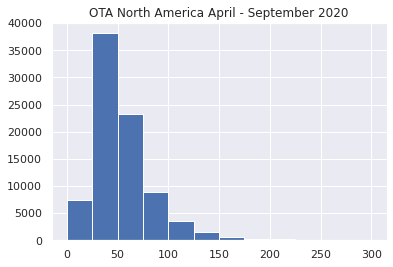

In [21]:
conus_ots.area_polygon.hist(bins=np.arange(0, 325, 25))
plt.title('OTA North America April - September 2020')

In [22]:
test = conus_ots.dropna(subset=['bedka_ota'])

In [23]:
test['eff_radius'] = np.sqrt(test.area_polygon)/np.pi
test['eff_diam'] = test.eff_radius * 2

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


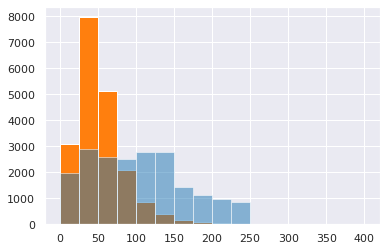

In [24]:
bins = np.arange(0, 425, 25)
test.area_polygon.hist(bins=bins, color='tab:orange', )
test.bedka_ota.hist(bins=bins, color='tab:blue', alpha=0.5)

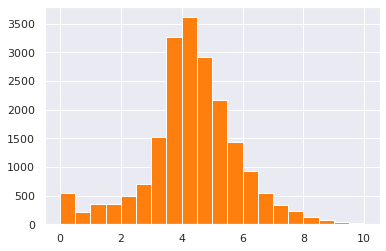

In [25]:
bins = np.arange(0, 10.5, .5)
test.eff_diam.hist(bins=bins, color='tab:orange', )

In [26]:
test['round_lat'] = round(test.lat_corr, 0)
test['round_lon'] = round(test.lon_corr, 0)

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 <a list of 10 Text major ticklabel objects>)

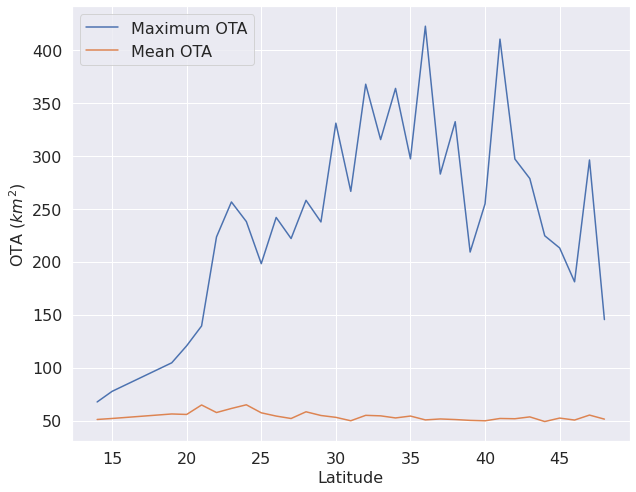

In [35]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
test.groupby('round_lat').max().area_polygon.plot(ax=ax, label='Maximum OTA')
test.groupby('round_lat').mean().area_polygon.plot(ax=ax, label='Mean OTA')

plt.xlabel('Latitude', fontsize=16)
plt.ylabel('OTA ($km^2$)', fontsize=16)

plt.legend(loc='upper left', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

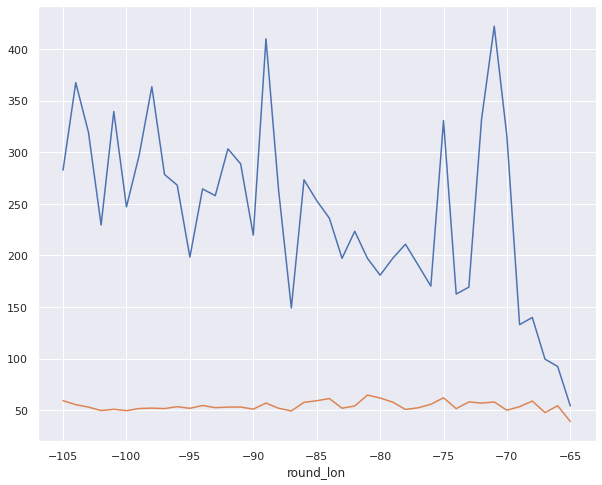

In [28]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
test.groupby('round_lon').max().area_polygon.plot(ax=ax)
test.groupby('round_lon').mean().area_polygon.plot(ax=ax)

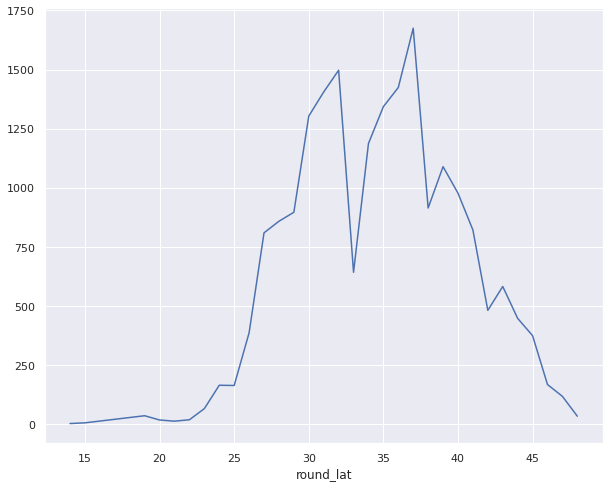

In [29]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
test.groupby('round_lat').count().area_polygon.plot(ax=ax)

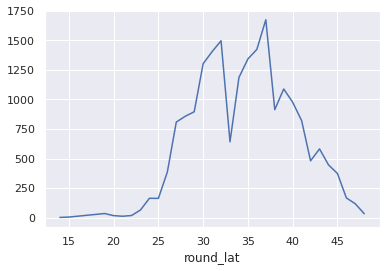

In [334]:
test.groupby('round_lat').count().bedka_ota.plot()

In [36]:
# Add an equal area projection using the central latitude and longitude from the dataset
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=cent_lon, central_latitude=cent_lat).proj4_params

# Project the datasets to the new coordinate reference system
ot_data_proj = conus_ots.to_crs(proj)
spc_events_proj = spc_events.to_crs(proj)

In [37]:
# Create a function to match OTs with their associated hazards
def match_report(hazard_df=None, ot_df=None, hazard_type='Hail', radius=60000, time_int=30, sort_priority='MAGNITUDE',
                 ascending=False):
    """
    Matches SPC reports with OTs using a given maximum radius
    and time interval
    
    Input
    ==============
    hazard_df = pandas dataframe with spc reports (should be subset for given hazard - ex. Tornado)
    
    ot_df = pandas dataframe with OT characteristics
    
    radius = maximum radius (units of meters) to match OTs with SPC reports
    
    time_int = maximum time interval (units of minutes) to match OTs with SPC reports
    
    Output
    ==============
    matched_df = Dataframe with OT/SPC report matches
    """
    
    hazard_df = hazard_df[hazard_df.EVENT_TYPE == hazard_type]
    
    if hazard_type == 'Tornado':
        hazard_df['MAGNITUDE'] = hazard_df.EF_RATING.dropna().astype(int)
    
    hazard_df = hazard_df.dropna(subset=['MAGNITUDE'])
    
    # Add a 60 km buffer to the SPC dataset
    hazard_df['geometry'] = hazard_df.buffer(radius)
    
    # Complete a spatial join between the two
    join_df = gpd.sjoin(ot_df, hazard_df, how='inner', op='intersects')
    
    # Create new columns for datetime of SPC hazard and OT
    join_df['haz_datetime'] = pd.to_datetime(join_df.datetime_utc)
    join_df['ota_datetime'] = pd.to_datetime(join_df.time).dt.tz_localize('utc')
    
    # Find the absolute value of the time difference
    join_df['abs_time_diff'] = abs(join_df.haz_datetime - join_df.ota_datetime)
    
    # Find where the time difference is less than or equal to 30 minutes
    matched_times = join_df[abs(join_df.abs_time_diff) <= timedelta(minutes=time_int)]
    
    # Sort through values - default is to take the one with the greatest magnitude (maximum hail)
    matched_df = matched_times.sort_values(sort_priority, ascending=ascending).drop_duplicates('EVENT_ID', 
                                                                                               keep='first')
    # Grab the OT with the largest OTA to make sure there are not any duplicates
    matched_df = matched_times.sort_values('area_polygon', ascending=False).drop_duplicates(['lon_corr', 'lat_corr'],
                                                                                         keep='first')
    
    return matched_df

In [38]:
def linear_regression(x, y):
    
    # Use x and y values to calculate stats
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    line = f'$r^{2}$={r:.3f}, p={p:.2f}, n={len(x)}'
    
    return np.array(x), intercept + slope * np.array(x), line

def plot_scatter(df, plot_field, area_field='area_polygon', s=50, color='tab:blue', title='test.png'):
    
    # Create the plots
    fig, ax = plt.subplots(1, 3, figsize=(20,8), sharex='col', sharey='row')
    
    #if plot_field == 'TOR_WIDTH':
    #    df['MAGNITUDE'] = df['TOR_WIDTH']
        
    ax[0].scatter(df.area_polygon.values,
                      df.MAGNITUDE, s=s, color=color)
    
    # Try to run the stats for each line
    try:
        x, y, line = linear_regression(df[area_field].values, df.MAGNITUDE.values)
        ax[0].plot(x, y, label=line, color='k', linewidth=3)
        ax[0].legend(loc='right', fontsize=16)
        
    except:
        None
    
    # Compare the minimum brightness temperature and magnitude of the hazard
    ax[1].scatter(df.btd.values,
                  df.MAGNITUDE, s=s, color=color)
    
    try:
        x, y, line = linear_regression(df.btd.values, df.MAGNITUDE.values)
        ax[1].plot(x, y, label=line, color='k', linewidth=3)
        ax[1].legend(loc='right', fontsize=16)
        
    except:
        None
        
    
    # Compare the OT depth and magnitude of the hazard
    ax[2].scatter(df.ot_depth.values,
                  df.MAGNITUDE, s=s, color=color)
    
    try:
        x, y, line = linear_regression(df.ot_depth.values, df.MAGNITUDE.values)
        ax[2].plot(x, y, label=line, color='k', linewidth=3)
        ax[2].legend(loc='center right', fontsize=16)
        
    except:
        None

    for axs in ax:
        axs.tick_params(direction='out', length=6, width=2, colors='k',
                        labelsize=16)
    
    # Add some labels to the x-axes
    ax[0].set_xlabel('OT Area ($km^{2}$)', fontsize=18)
    ax[1].set_xlabel('Brightness Temperature \n Difference (K)', fontsize=18)
    ax[2].set_xlabel('OT Depth (km)', fontsize=18)

    # Add the y-axis label from user input
    ax[0].set_ylabel(plot_field, fontsize=18)
    
    plt.savefig(title, dpi=300);

In [39]:
# Convert columns to datetime
ot_data_proj['time'] = pd.to_datetime(ot_data_proj.time)
spc_events_proj['BEGIN_DATE_TIME'] = pd.to_datetime(spc_events_proj.BEGIN_DATE_TIME)

In [40]:
# Add date and month columns to each dataset
ot_data_proj['day'] = ot_data_proj.sort_values('time').time.dt.day
ot_data_proj['month'] = ot_data_proj.sort_values('time').time.dt.month

spc_events_proj['day'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.day
spc_events_proj['month'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.month

In [41]:
ot_data_proj['btd'] = ot_data_proj.mintb - ot_data_proj.tropopause_temperature
ot_data_proj['ot_depth'] = ot_data_proj.tropopause_height - ot_data_proj.cloudtop_height

In [42]:
# Create lists to store dataframes
hail_list = []
wind_list = []
torn_list = []

# Iterate over each day to analyze reports to remove duplicates and maximize matches
for month in ot_data_proj.month.unique():
    ot_df = ot_data_proj[ot_data_proj.month == month]
    spc_df = spc_events_proj[spc_events_proj.month == month]
    for day in ot_df.day.unique():
        sub_ot = ot_df[ot_df.day == day]
        sub_spc = spc_df[spc_df.day == day]
        hail_list.append(match_report(sub_spc, sub_ot, hazard_type='Hail', radius=45000, time_int=35))
        wind_list.append(match_report(sub_spc, sub_ot, hazard_type='Thunderstorm Wind', radius=45000, time_int=35))
        torn_list.append(match_report(sub_spc, sub_ot, hazard_type='Tornado', radius=45000, time_int=35))

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [43]:
hail_matched = pd.concat(hail_list)
wind_matched = pd.concat(wind_list)
torn_matched = pd.concat(torn_list)

In [44]:
mean_hail = hail_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'bedka_ota','btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

In [45]:
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)

In [46]:
torn_matched['prop_damage'] = torn_matched.DAMAGE_PROPERTY.str.extract('(\d+)').fillna(0).astype(int)
good_tors = torn_matched[torn_matched.prop_damage > 0]

torn_matched = good_tors.dropna(subset=['area_polygon', 'MAGNITUDE', 'btd', 'datetime_utc'])
mean_torn = good_tors[['EPISODE_ID_y', 'MAGNITUDE', 'area_polygon', 'bedka_ota', 'btd', 'TOR_WIDTH', 'ot_depth', 
                       'datetime_utc']].groupby('EPISODE_ID_y').max()

mean_torn['round_width'] = np.round(mean_torn['TOR_WIDTH'], -2)

In [61]:
hail_matched[(hail_matched.day_left == 10) & (hail_matched.month_left == 8)].EPISODE_ID_x.values

array([152039, 152240, 149375, 149375, 151730, 149375, 149375, 149375,
       149375, 149375, 149375, 149375, 149375, 149375, 149375, 152240,
       149375, 149375, 149375, 149375, 151730, 149375, 149375, 149375,
       149375, 149375, 149375, 149375, 150384, 149375, 152240, 149375,
       149375, 149375, 149375, 149375, 149375, 149375, 151885, 149375,
       151730, 149375, 149375, 149375, 149375, 150363, 151730, 149375,
       149375, 151730, 149375, 149375, 149375, 151397, 151730, 149375,
       149375, 149375, 149375, 151730, 151885, 150384, 149375, 151730,
       149375, 149375, 149375, 150384, 151730, 149375, 151730, 149375,
       149375, 149375, 151730, 149375, 149375, 149375, 149375, 149375,
       151777, 149375, 149375, 149375, 149375, 149375, 149375, 149375,
       149375, 149375, 149375, 149375, 149375, 149375, 149375, 151730,
       151730, 149375, 149375, 149375, 149375, 151730, 152240, 149375,
       149375, 149375, 149375, 151730, 149375, 149375, 149375, 151730,
      

In [80]:
hail_matched[hail_matched.EPISODE_ID_x == episode].EPISODE_NARRATIVE.values

array(['A weak cold front worked through eastern Minnesota during the early morning hours of the 10th. A few isolated showers and storms developed ahead of the front and one storm became severe producing large hail and minor wind damage over part of Pine County.',
       'A weak cold front worked through eastern Minnesota during the early morning hours of the 10th. A few isolated showers and storms developed ahead of the front and one storm became severe producing large hail and minor wind damage over part of Pine County.',
       'A weak cold front worked through eastern Minnesota during the early morning hours of the 10th. A few isolated showers and storms developed ahead of the front and one storm became severe producing large hail and minor wind damage over part of Pine County.',
       'A weak cold front worked through eastern Minnesota during the early morning hours of the 10th. A few isolated showers and storms developed ahead of the front and one storm became severe producing l

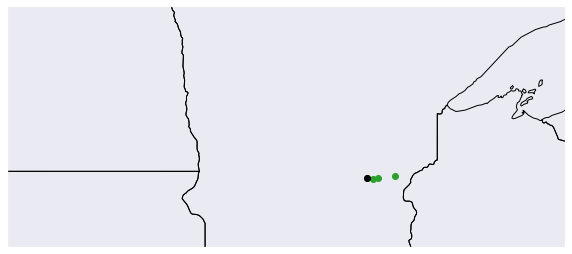

In [89]:
episode = 152240
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES)

hail_matched[hail_matched.EPISODE_ID_x == episode].to_crs('EPSG:4326').plot(color='tab:green', ax=ax)
hail_matched[hail_matched.area_polygon == mean_hail[mean_hail.index == episode].area_polygon.values[0]].to_crs('EPSG:4326').plot(color='black', ax=ax)

ax.set_extent([-100, -90, 45, 48])

#plt.title(f'Hail from Episode {episode} \n 4 April 2017')
plt.show()
plt.close()

In [82]:
plt.scatter(max_hail.area_polygon, max_hail.MAGNITUDE)

NameError: name 'max_hail' is not defined

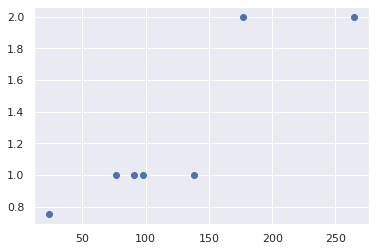

In [267]:
plt.scatter(mean_hail.area_polygon, mean_hail.MAGNITUDE)

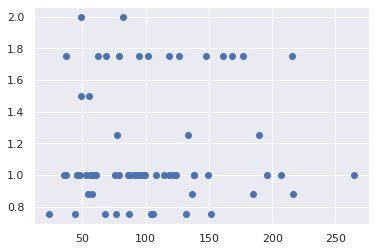

In [186]:
plt.scatter(max_hail.area_polygon, max_hail.MAGNITUDE)

Text(0.5, 0.98, 'Tornado Width and OTA')

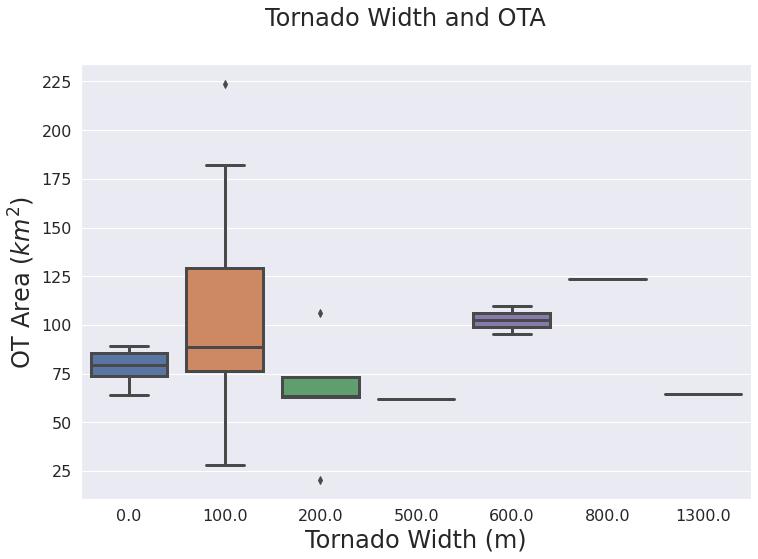

In [62]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_width',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('Tornado Width (m)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Width and OTA', fontsize=24)
#plt.savefig('tornado_width_ota.png', dpi=300)

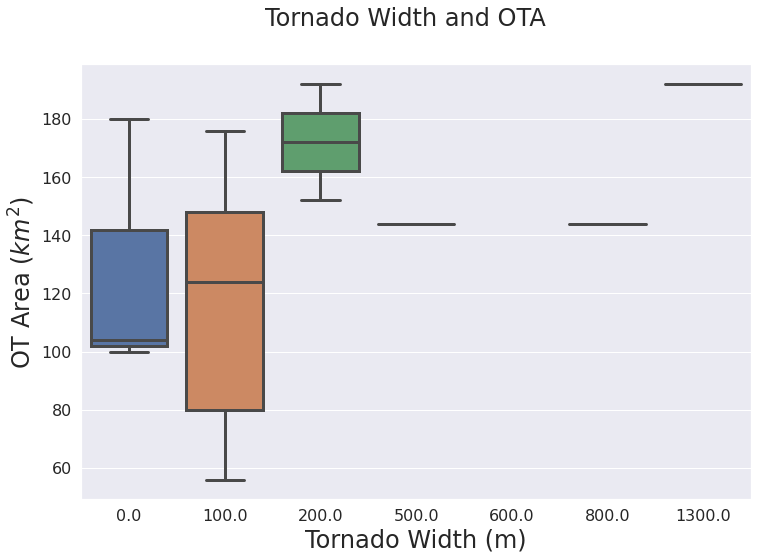

In [93]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='bedka_ota', x='round_width',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('Tornado Width (m)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Width and OTA', fontsize=24)
plt.savefig('tornado_width_ota.png', dpi=300)

In [ ]:
error = 2 * a * np.sqrt()

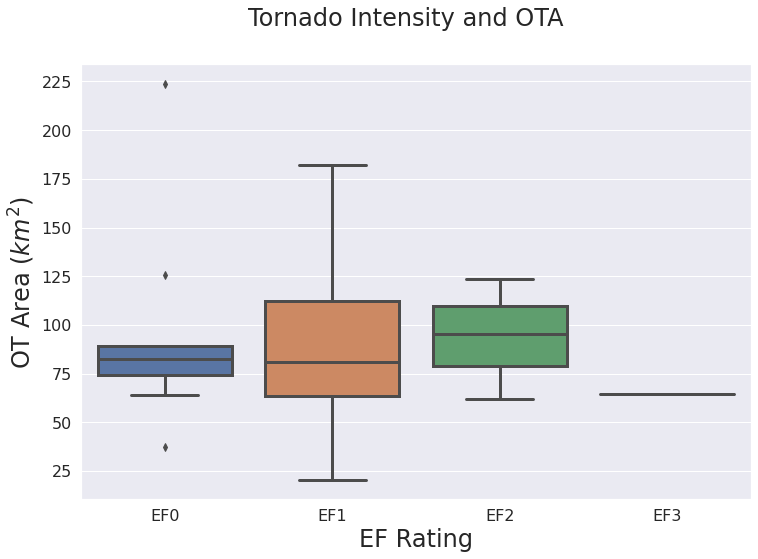

In [92]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='MAGNITUDE',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('EF Rating', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(np.arange(4), ['EF0', 'EF1', 'EF2', 'EF3'], fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Intensity and OTA', fontsize=24)
plt.savefig('tornado_intensity_ota.png', dpi=300)

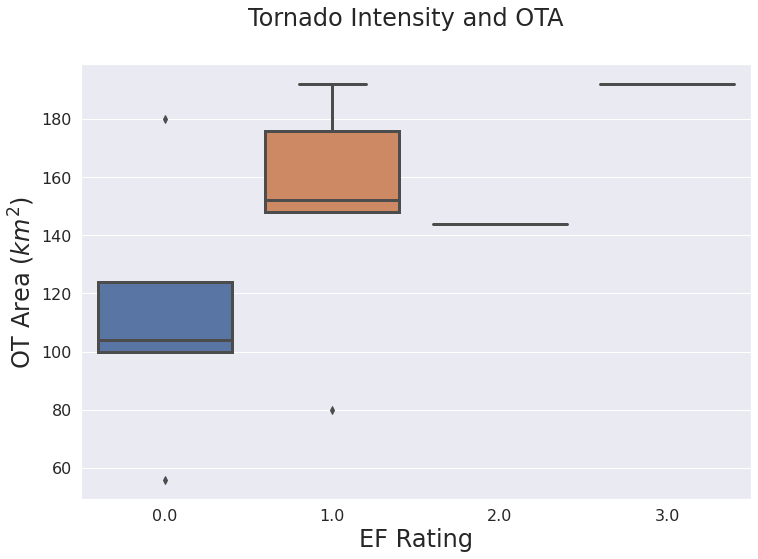

In [84]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='bedka_ota', x='MAGNITUDE',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('EF Rating', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Intensity and OTA', fontsize=24)
plt.savefig('tornado_intensity_ota.png', dpi=300)

In [138]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

In [55]:
hail_matched_better = hail_matched[hail_matched.MAGNITUDE >= 1]
mean_hail = hail_matched_better[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

In [94]:
mean_wind = wind_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'btd', 'ot_depth']].groupby('EPISODE_ID_x').max()

In [95]:
mean_wind['round_wind'] = (mean_wind.MAGNITUDE // 5) * 5

In [96]:
mean_wind = mean_wind[mean_wind.area_polygon < 500]

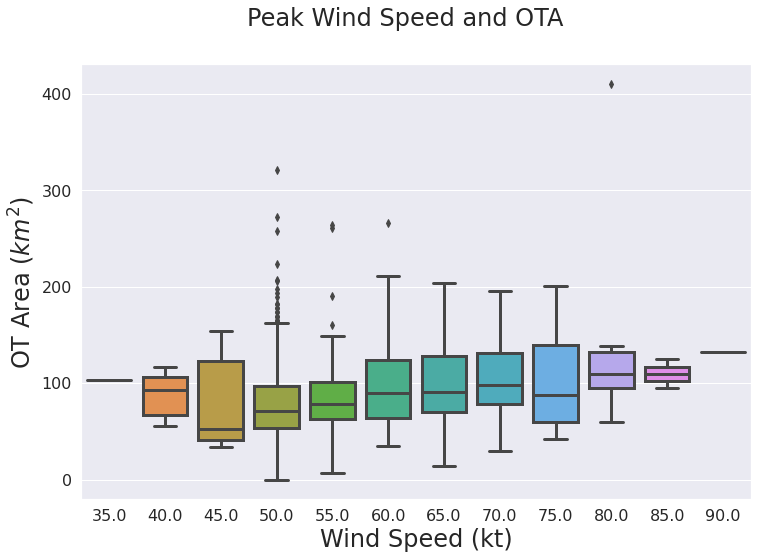

In [97]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_wind',ax=ax, linewidth=3, data=mean_wind)
plt.xlabel('Wind Speed (kt)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Peak Wind Speed and OTA', fontsize=24)

plt.savefig('wind_boxplot_2017_2020.png', dpi=300)

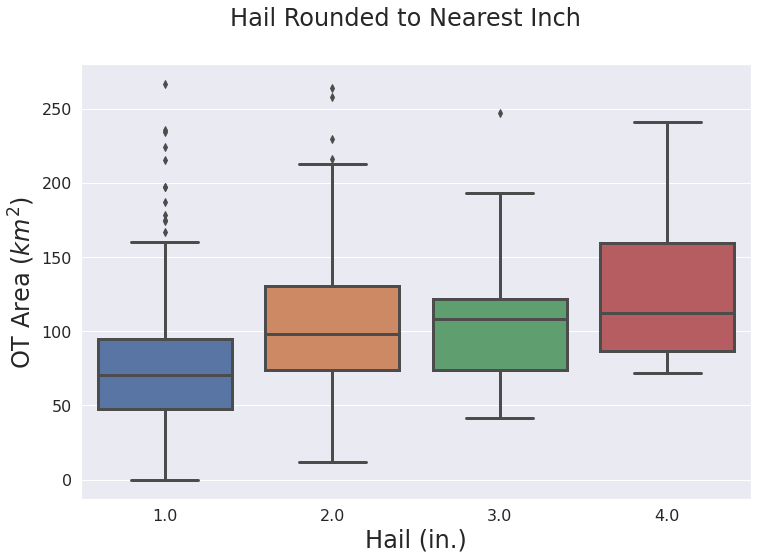

In [85]:
plt.figure(figsize=(12,8))
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_may_2017.png', dpi=300)

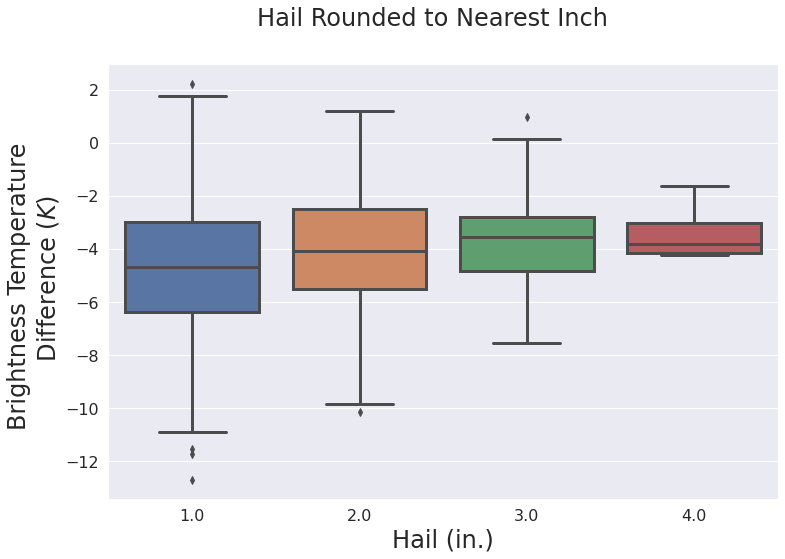

In [87]:
plt.figure(figsize=(12,8))
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
ax = plt.subplot(111)
sns.boxplot(y='btd', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('Brightness Temperature \n Difference ($K$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_btd.png', dpi=300)

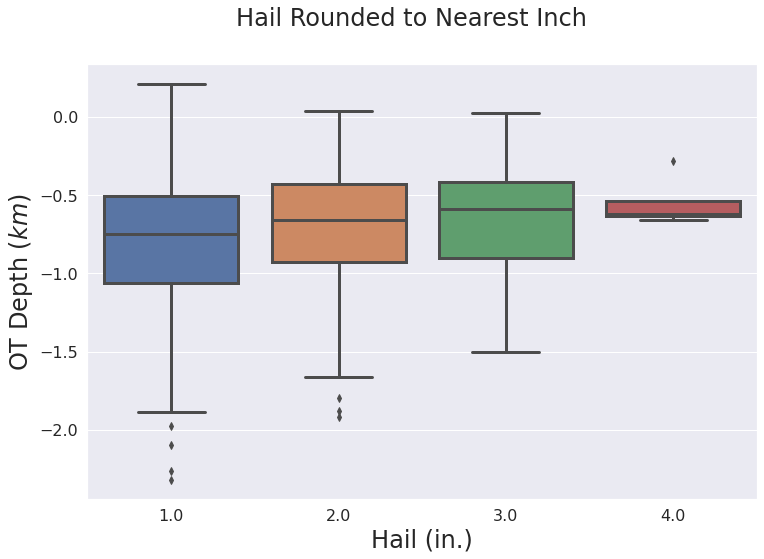

In [103]:
plt.figure(figsize=(12,8))
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)
ax = plt.subplot(111)
sns.boxplot(y='ot_depth', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('OT Depth ($km$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_otd.png', dpi=300)
#plt.savefig('hail_boxplot_may_2017.png', dpi=300)

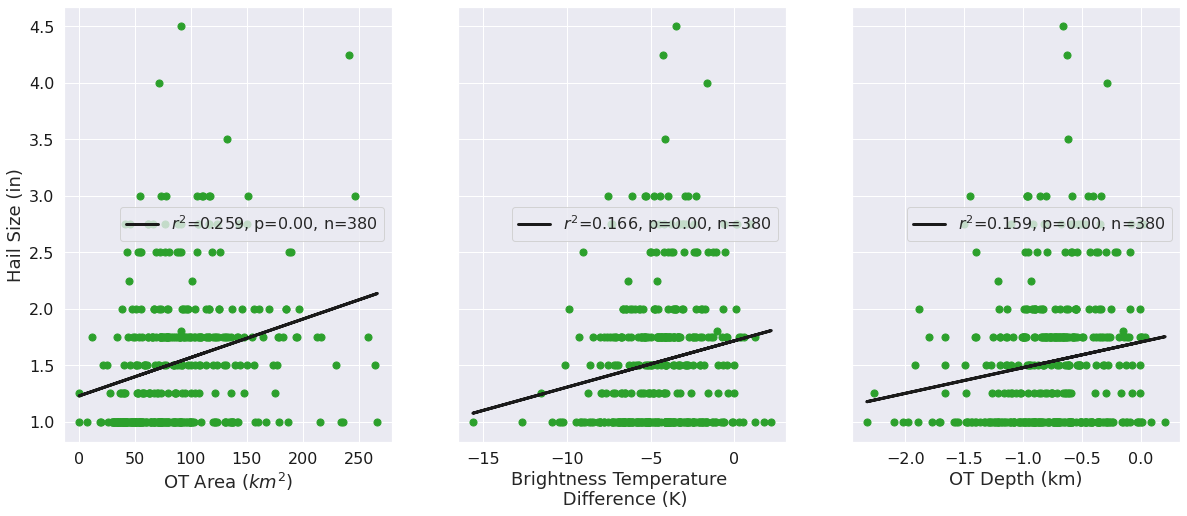

In [70]:
plot_scatter(mean_hail, 'Hail Size (in)', s=50, color='tab:green', title='Hail_OT.png')

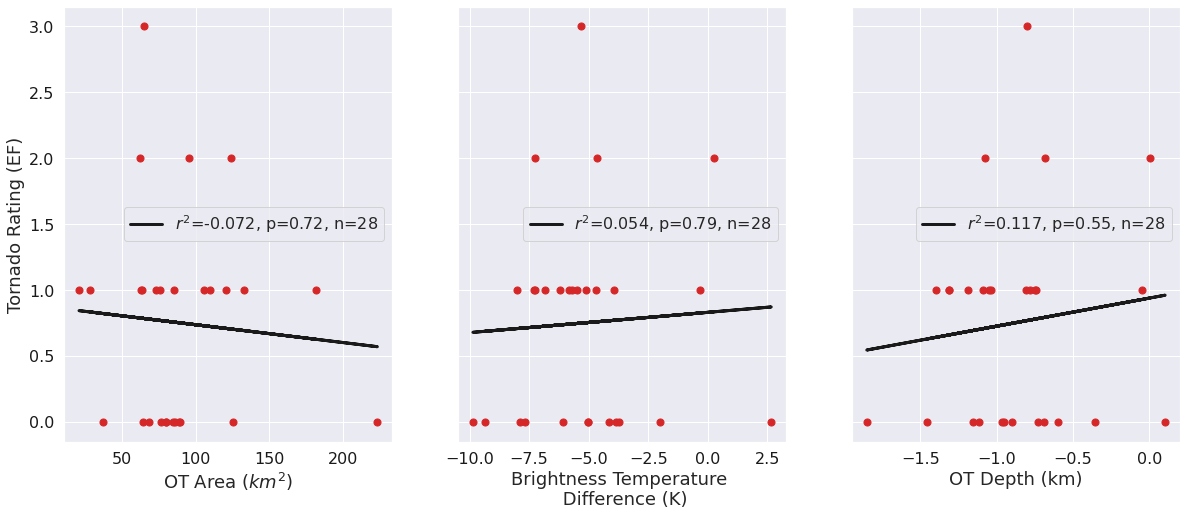

In [91]:
plot_scatter(mean_torn, 'Tornado Rating (EF)', 'area_polygon', s=50, color='tab:red', title='tornado_ot_may_2017.png')

---
## Now for the mesoscale domain sector

In [171]:
# Add an equal area projection using the central latitude and longitude from the dataset
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=cent_lon, central_latitude=cent_lat).proj4_params

# Project the datasets to the new coordinate reference system
ot_data_proj = meso_ots.to_crs(proj)
spc_events_proj = spc_events.to_crs(proj)

In [172]:
# Convert columns to datetime
ot_data_proj['time'] = pd.to_datetime(ot_data_proj.time)
spc_events_proj['BEGIN_DATE_TIME'] = pd.to_datetime(spc_events_proj.BEGIN_DATE_TIME)

ot_data_proj['btd'] = ot_data_proj.mintb - ot_data_proj.tropopause_temperature

# Add date and month columns to each dataset
ot_data_proj['day'] = ot_data_proj.sort_values('time').time.dt.day
ot_data_proj['month'] = ot_data_proj.sort_values('time').time.dt.month

spc_events_proj['day'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.day
spc_events_proj['month'] = spc_events_proj.sort_values('datetime_utc').datetime_utc.dt.month

In [173]:
# Create lists to store dataframes
hail_list = []
wind_list = []
torn_list = []

# Iterate over each day to analyze reports to remove duplicates and maximize matches
for month in ot_data_proj.month.unique():
    ot_df = ot_data_proj[ot_data_proj.month == month]
    spc_df = spc_events_proj[spc_events_proj.month == month]
    for day in ot_df.day.unique():
        sub_ot = ot_df[ot_df.day == day]
        sub_spc = spc_df[spc_df.day == day]
        hail_list.append(match_report(sub_spc, sub_ot, hazard_type='Hail', radius=45000, time_int=35))
        wind_list.append(match_report(sub_spc, sub_ot, hazard_type='Thunderstorm Wind', radius=45000, time_int=35))
        torn_list.append(match_report(sub_spc, sub_ot, hazard_type='Tornado', radius=45000, time_int=35))

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [179]:
hail_matched = pd.concat(hail_list)
wind_matched = pd.concat(wind_list)
torn_matched = pd.concat(torn_list)

In [180]:
mean_hail = hail_matched[['EPISODE_ID_x', 'MAGNITUDE', 'area_polygon', 'bedka_ota','btd']].groupby('EPISODE_ID_x').max()

In [181]:
mean_hail['round_hail'] = np.round(mean_hail['MAGNITUDE'], 0)

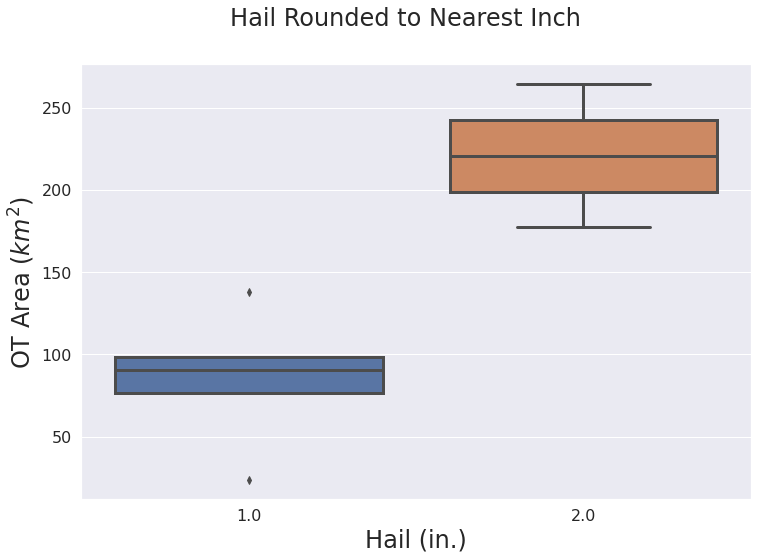

In [182]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_hail',ax=ax, linewidth=3, data=mean_hail)
plt.xlabel('Hail (in.)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Hail Rounded to Nearest Inch', fontsize=24)

plt.savefig('hail_boxplot_may_2017.png', dpi=300)

In [178]:
torn_matched['prop_damage'] = torn_matched.DAMAGE_PROPERTY.str.extract('(\d+)').fillna(0).astype(int)
good_tors = torn_matched[torn_matched.prop_damage > 0]

torn_matched = good_tors.dropna(subset=['area_polygon', 'MAGNITUDE', 'btd'])
mean_torn = good_tors[['EPISODE_ID_y', 'MAGNITUDE', 'area_polygon', 'bedka_ota', 'btd', 'TOR_WIDTH']].groupby('EPISODE_ID_y').max()

mean_torn['round_width'] = np.round(mean_torn['TOR_WIDTH'], -2)

In [186]:
mean_torn

,MAGNITUDE,area_polygon,bedka_ota,btd,TOR_WIDTH,round_width
EPISODE_ID_y,,,,,,
113448,0,93.730312,244.0,-3.470001,40.0,0.0
113801,1,110.456260,244.0,-2.110001,250.0,200.0
115772,2,133.580323,244.0,2.860001,1320.0,1300.0


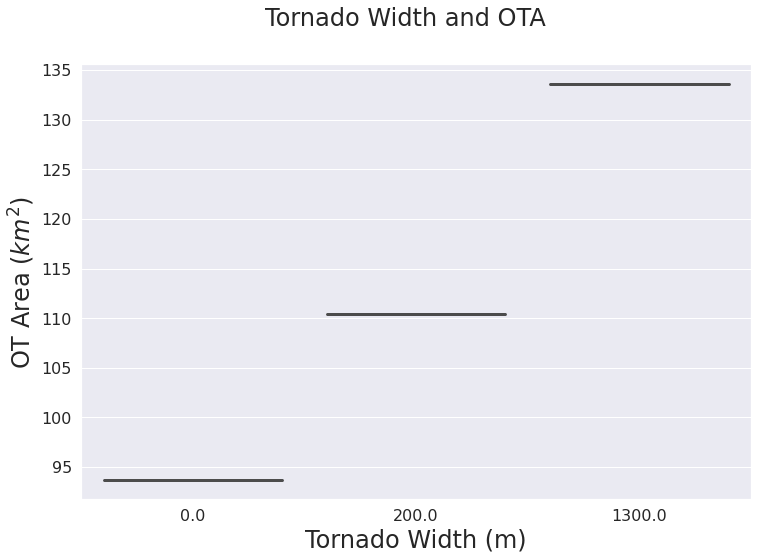

In [187]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='round_width',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('Tornado Width (m)', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Width and OTA', fontsize=24)
plt.savefig('tornado_width_ota.png', dpi=300)

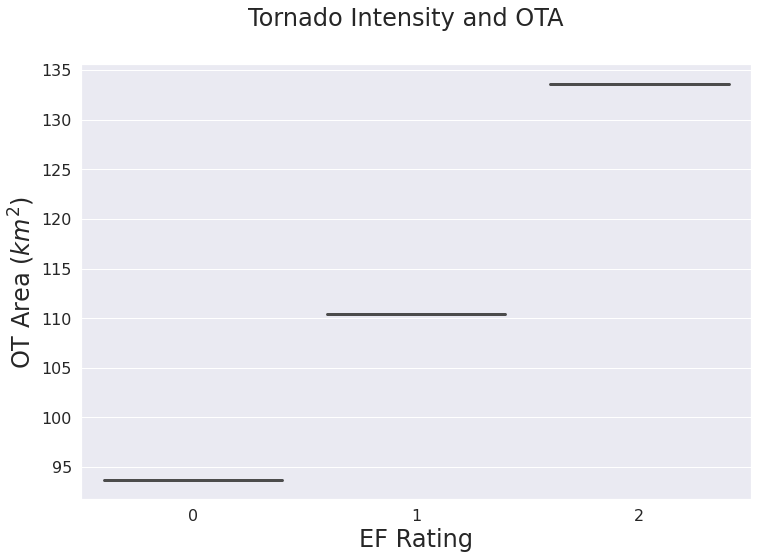

In [188]:
plt.figure(figsize=(12,8))

ax = plt.subplot(111)
sns.boxplot(y='area_polygon', x='MAGNITUDE',ax=ax, linewidth=3, data=mean_torn)
plt.xlabel('EF Rating', fontsize=24)
plt.ylabel('OT Area ($km^{2}$)', fontsize=24)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(None)

plt.suptitle('Tornado Intensity and OTA', fontsize=24)
plt.savefig('tornado_intensity_ota.png', dpi=300)

/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/conda/envs/geoai-py3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


AttributeError: 'DataFrame' object has no attribute 'ot_depth'

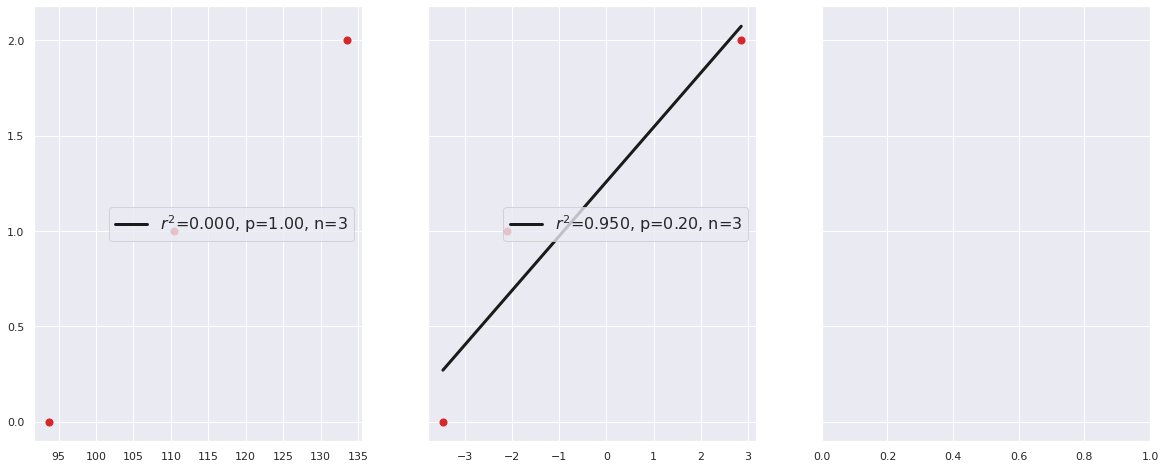

In [189]:
plot_scatter(mean_torn, 'Tornado Rating (EF)', 'bedka_ota', s=50, color='tab:red', title='tornado_ot_may_2017.png')

In [211]:
print(np.percentile(hail_matched[hail_matched.MAGNITUDE <= 1].area_polygon.values, 95))
print(np.percentile(hail_matched[hail_matched.MAGNITUDE > 1].area_polygon.values, 95))

112.35119495592888
148.8724766701648


In [204]:
np.percentile

<function numpy.percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)>